In [1]:
import sys, os
import sparse
import xsimlab as xs
import xarray as xr
import numpy as np
import pandas as pd
import igraph as ig
from pgljupyter import SceneWidget

In [2]:
sys.path.insert(0, os.path.join(os.getcwd(), '..'))
import vmlab
from vmlab.models.vmango import vmango as model
from vmlab.enums import Nature

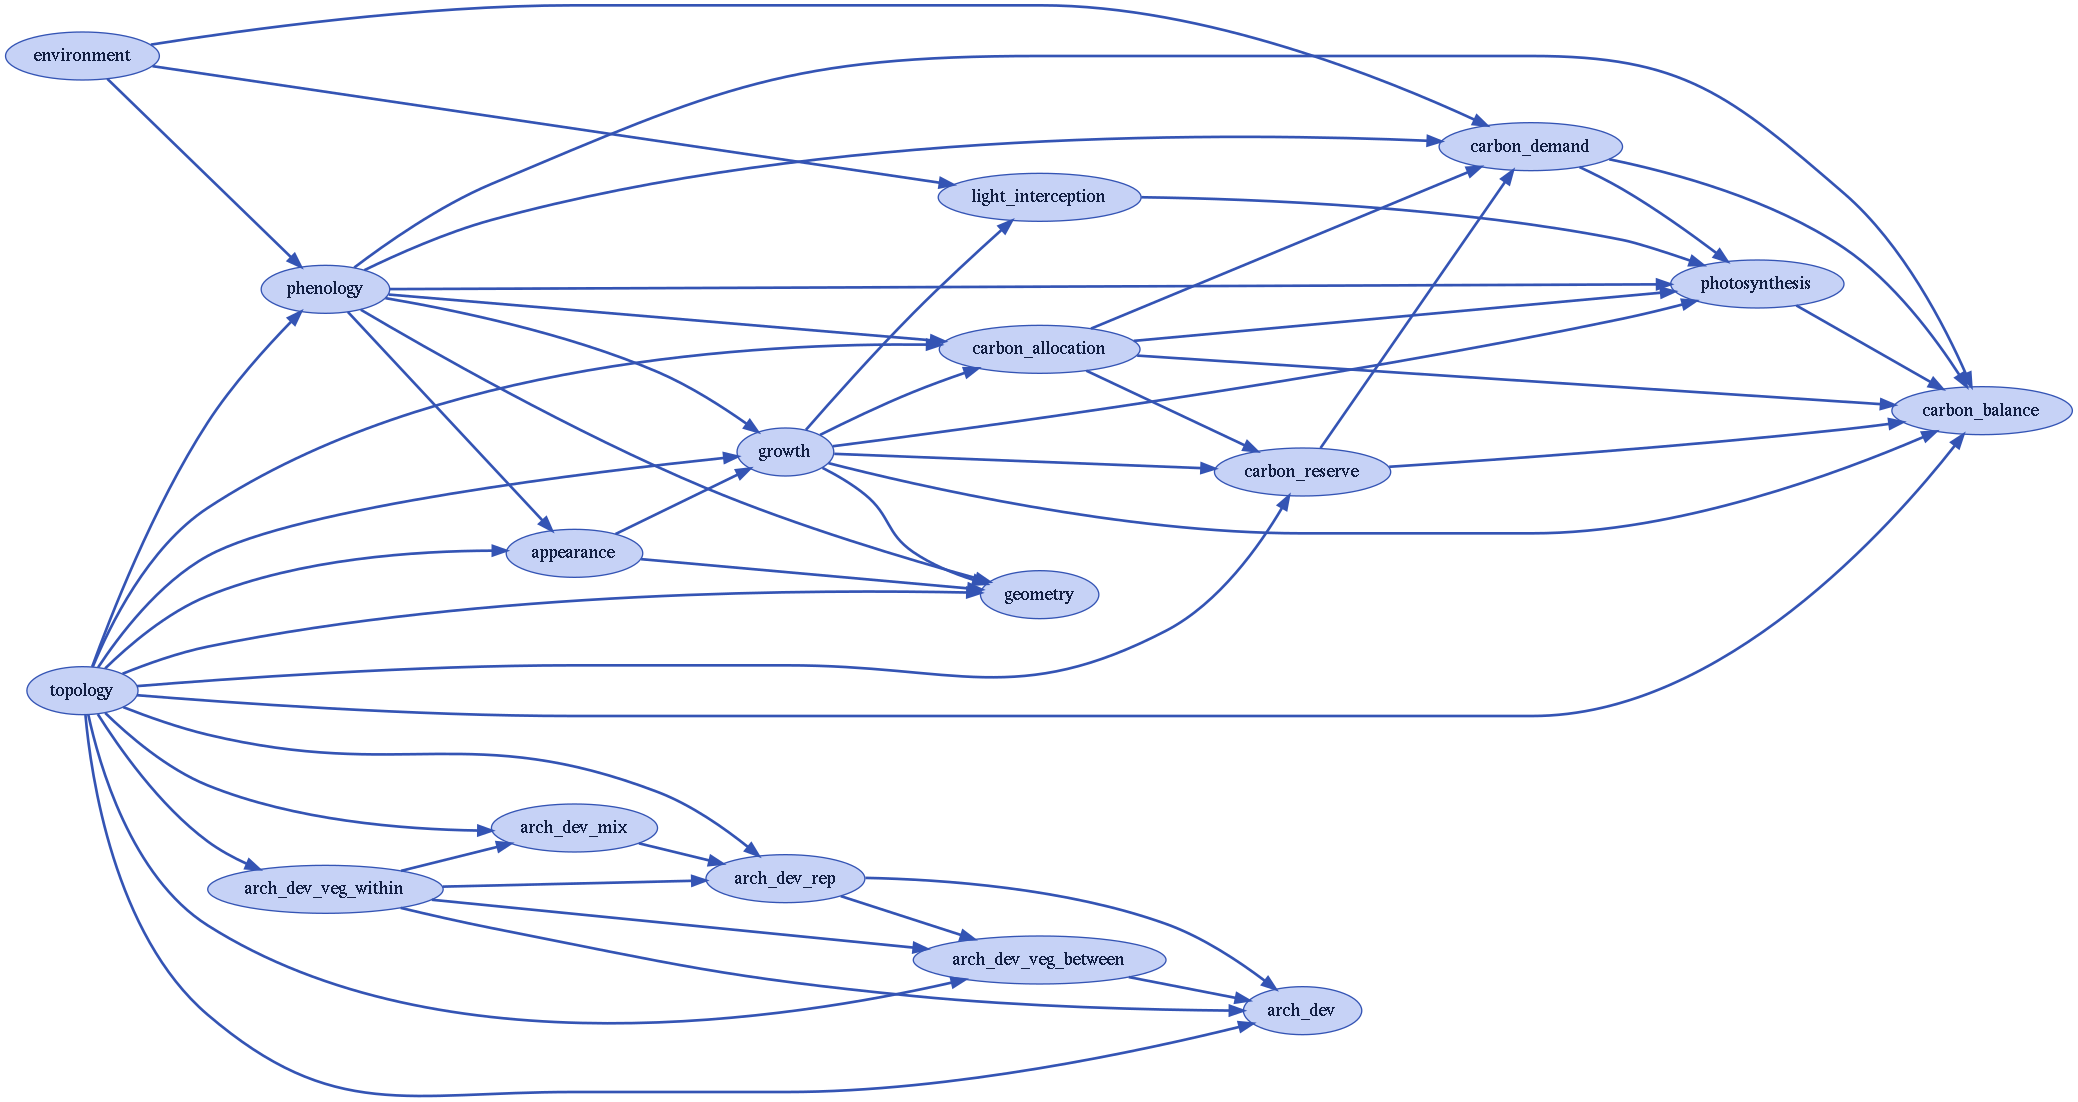

In [3]:
model = model.drop_processes(['fruit_quality'])
model.visualize()

In [4]:
tree = pd.DataFrame({
    'id': [0, 1],
    'parent_id': [np.nan, 0],
    'cycle': [3, 3],
    'is_apical': [1, 1],
    'appearance_month': [2, 2],
    'ancestor_nature': [0, 0],
    'ancestor_is_apical': [1, 1]
})
tree

,id,parent_id,cycle,is_apical,appearance_month,ancestor_nature,ancestor_is_apical
0,0,NaN,3,1,2,0,1
1,1,0.0,3,1,2,0,1


In [5]:
ds = vmlab.create_setup(
    model,
    initial_tree_df=tree,
    start_date='2002-06-01',
    end_date='2004-03-01',
    setup_toml='../share/setup/vmango.toml',
    current_cycle=3,
    input_vars={
        'topology': {
            'seed': 11,
            'month_begin_veg_cycle': 7,
            'doy_begin_flowering': 214
        },
        'geometry__interpretation_freq': 3
    },
    output_vars={
        'photosynthesis': {
            'photo': 'day',
            'D_fruit_avg': 'day'
        },
        'phenology': {
            'inflo_stage': 'day',
            'nb_fruit': 'day'
        },
        'carbon_demand': {
            'D_fruit': 'day',
            'MR_stem': 'day',
            'MR_leaf': 'day',
            'MR_fruit': 'day',
            
        },
        'carbon_reserve': {
            'DM_structural_stem': 'day',
            'DM_structural_leaf': 'day',
            'reserve_stem': 'day',
            'reserve_leaf': 'day',
            'reserve_mob': 'day',
            'reserve_nmob_stem': 'day',
            'reserve_nmob_leaf': 'day',
            'reserve_leaf_max': 'day'
        },
        'carbon_balance': {
            'carbon_supply': 'day',
            'DM_fruit': 'day',
            'reserve_stem_delta': 'day',
            'reserve_leaf_delta': 'day',
            'reserve_nmob_stem_delta': 'day',
            'reserve_nmob_leaf_delta': 'day',
            'remains_1': 'day',
            'required_DM_fruit': 'day'
        }
    }
)

In [6]:
sw = SceneWidget(size_world=2.5)
sw

SceneWidget(scenes=[{'id': 'SWOZimjsbkV5tMNspw5dFuVfU', 'data': b'x\xdaSLrw\xf5\xf7e`Pp\xe0\xe5RPVVd\x00\x020\…

In [7]:
scene_ = None
@xs.runtime_hook(stage='run_step')
def hook(model, context, state):
    global scene_
    scene = state[('geometry', 'scene')]
    if scene != scene_:
        sw.set_scenes([scene], scales=[1/100])
        scene_ = scene
    
ds_out = ds.xsimlab.run(model=model, decoding={ 'mask_and_scale': False }, hooks=[xs.monitoring.ProgressBar(), hook])
ds_out

             0% | initialize 

<xarray.Dataset>
Dimensions:                                             (GU: 15, day: 640, hour: 24)
Coordinates:
  * GU                                                  (GU) <U10 'GU0' ... '...
  * day                                                 (day) datetime64[ns] ...
  * hour                                                (hour) int8 0 1 ... 23
Data variables:
    appearance__appeared                                (GU) float32 1.0 ... 1.0
    appearance__final_length_gu                         (GU) float32 19.27 .....
    appearance__final_length_inflos                     (GU) object None ... ...
    appearance__final_length_internodes                 (GU) object [0.836614...
    appearance__final_length_leaves                     (GU) object [16.90862...
    appearance__nb_internode                            (GU) float32 17.0 ......
    appearance__parameter_file_path                     <U40 '../share/setup/...
    arch_dev__pot_burst_date                            (GU) datetime64[D] Na...
    arch_dev__pot_flowering_date                        (GU) datetime64[D] Na...
    arch_dev__pot_has_apical_child                      (GU) float32 0.0 ... 0.0
    arch_dev__pot_nature                                (GU) float32 0.0 ... 2.0
    arch_dev__pot_nb_fruit                              (GU) float32 0.0 ... 1.0
    arch_dev__pot_nb_inflo                              (GU) float32 0.0 ... 1.0
    arch_dev__pot_nb_lateral_children                   (GU) float32 0.0 ... 0.0
    arch_dev_mix__has_mixed_inflo_children_between      (GU) float32 0.0 ... 0.0
    arch_dev_mix__parameter_file_path                   <U46 '../share/setup/...
    arch_dev_rep__flowering                             (GU) float32 0.0 ... 1.0
    arch_dev_rep__flowering_date                        (GU) datetime64[D] Na...
    arch_dev_rep__flowering_week                        (GU) float32 0.0 ... 5.0
    arch_dev_rep__fruiting                              (GU) float32 0.0 ... 1.0
    arch_dev_rep__nature                                (GU) float32 0.0 ... 2.0
    arch_dev_rep__nb_fruits                             (GU) float32 0.0 ... 1.0
    arch_dev_rep__nb_inflorescences                     (GU) float32 0.0 ... 1.0
    arch_dev_rep__parameter_file_path                   <U46 '../share/setup/...
    arch_dev_veg_between__burst_date_children_between   (GU) datetime64[D] Na...
    arch_dev_veg_between__burst_month_children_between  (GU) int8 5 5 0 ... 0 0
    arch_dev_veg_between__has_apical_child_between      (GU) float32 0.0 ... 0.0
    arch_dev_veg_between__has_lateral_children_between  (GU) float32 0.0 ... 0.0
    arch_dev_veg_between__has_veg_children_between      (GU) float32 0.0 ... 0.0
    arch_dev_veg_between__nb_lateral_children_between   (GU) float32 0.0 ... 0.0
    arch_dev_veg_between__parameter_file_path           <U54 '../share/setup/...
    arch_dev_veg_within__burst_date_children_within     (GU) datetime64[D] Na...
    arch_dev_veg_within__burst_month_children_within    (GU) int8 5 5 2 ... 0 0
    arch_dev_veg_within__has_apical_child_within        (GU) float32 0.0 ... 0.0
    arch_dev_veg_within__has_lateral_children_within    (GU) float32 0.0 ... 0.0
    arch_dev_veg_within__has_veg_children_within        (GU) float32 0.0 ... 0.0
    arch_dev_veg_within__nb_lateral_children_within     (GU) float32 0.0 ... 0.0
    arch_dev_veg_within__parameter_file_path            <U53 '../share/setup/...
    carbon_allocation__is_photo_active                  (GU) float32 0.0 ... 0.0
    carbon_allocation__parameter_file_path              <U51 '../share/setup/...
    carbon_balance__DM_fruit                            (day, GU) float32 0.0...
    carbon_balance__DM_fruit_delta                      (GU) float32 0.0 ... 0.0
    carbon_balance__carbon_supply                       (day, GU) float32 0.0...
    carbon_balance__parameter_file_path                 <U48 '../share/setup/...
    carbon_balance__remains_1                           (day, GU) 

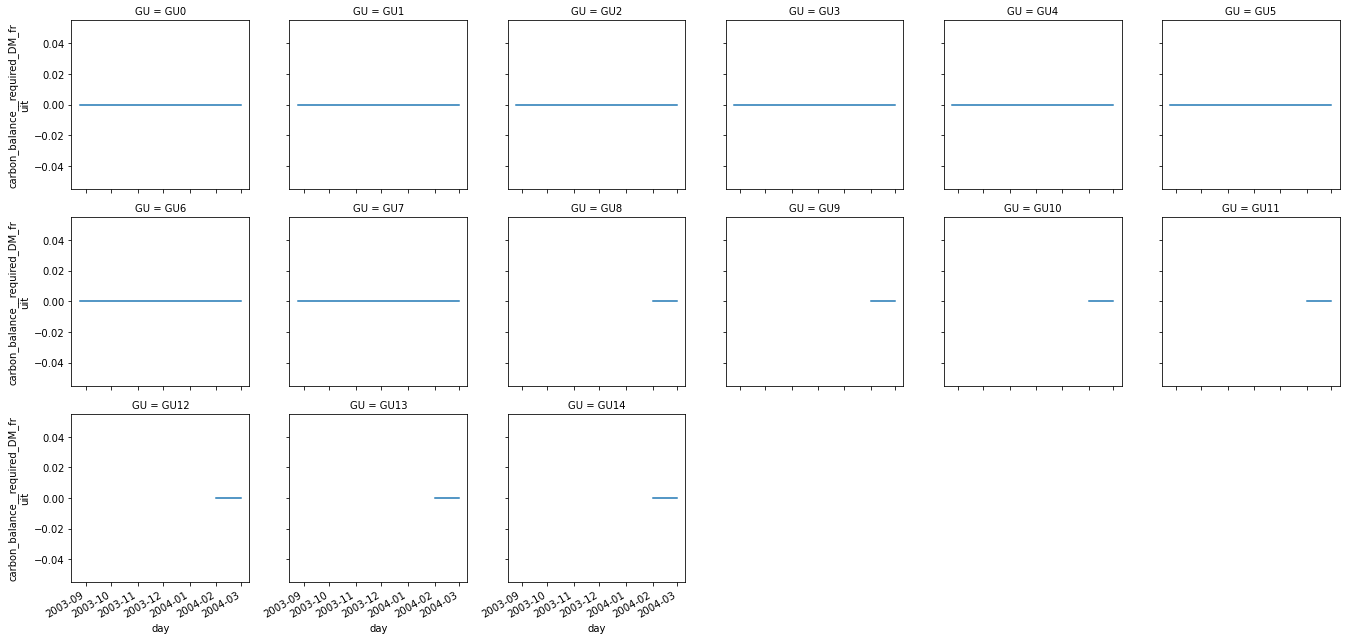

In [8]:
ds_out.carbon_balance__required_DM_fruit[450:,:].plot(col='GU', col_wrap=6)

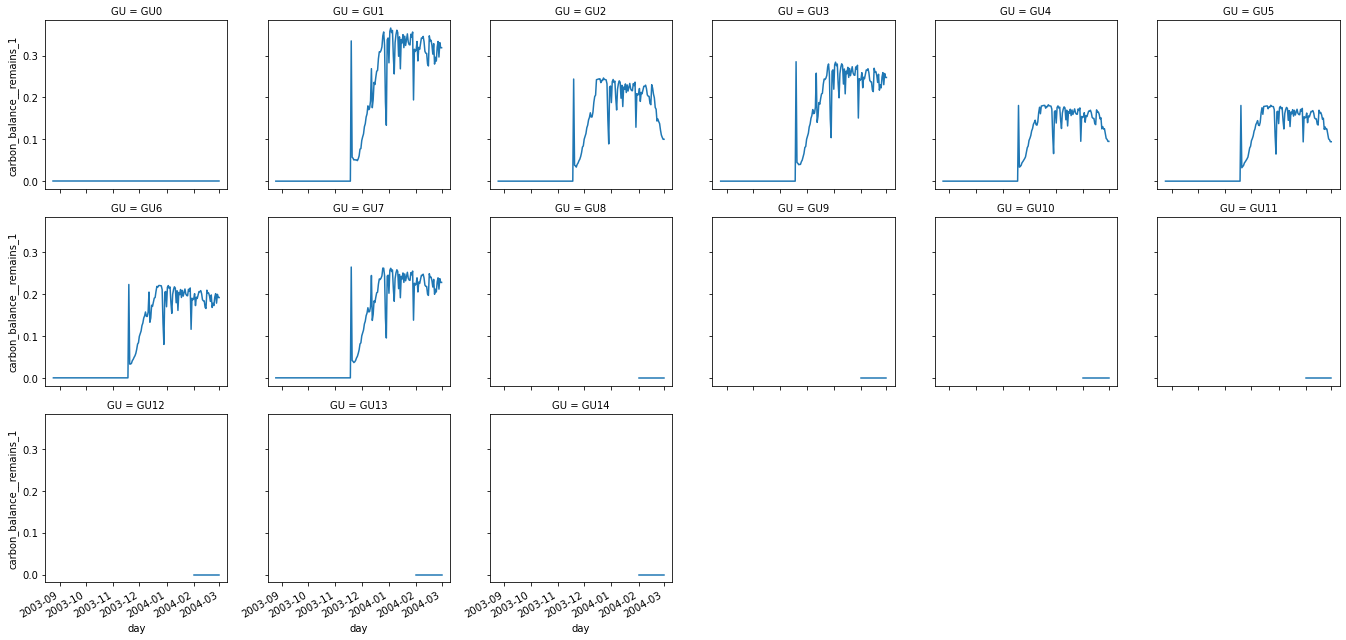

In [9]:
ds_out.carbon_balance__remains_1[450:,:].plot(col='GU', col_wrap=6)

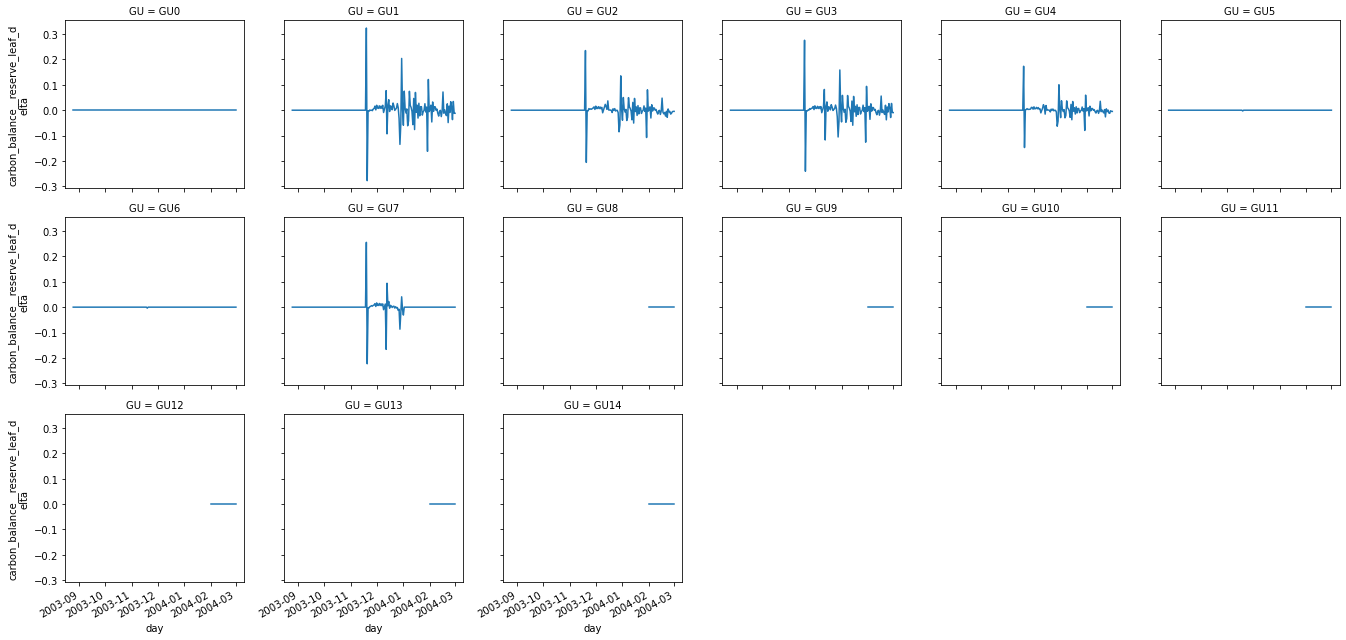

In [10]:
ds_out.carbon_balance__reserve_leaf_delta[450:,:].plot(col='GU', col_wrap=6)

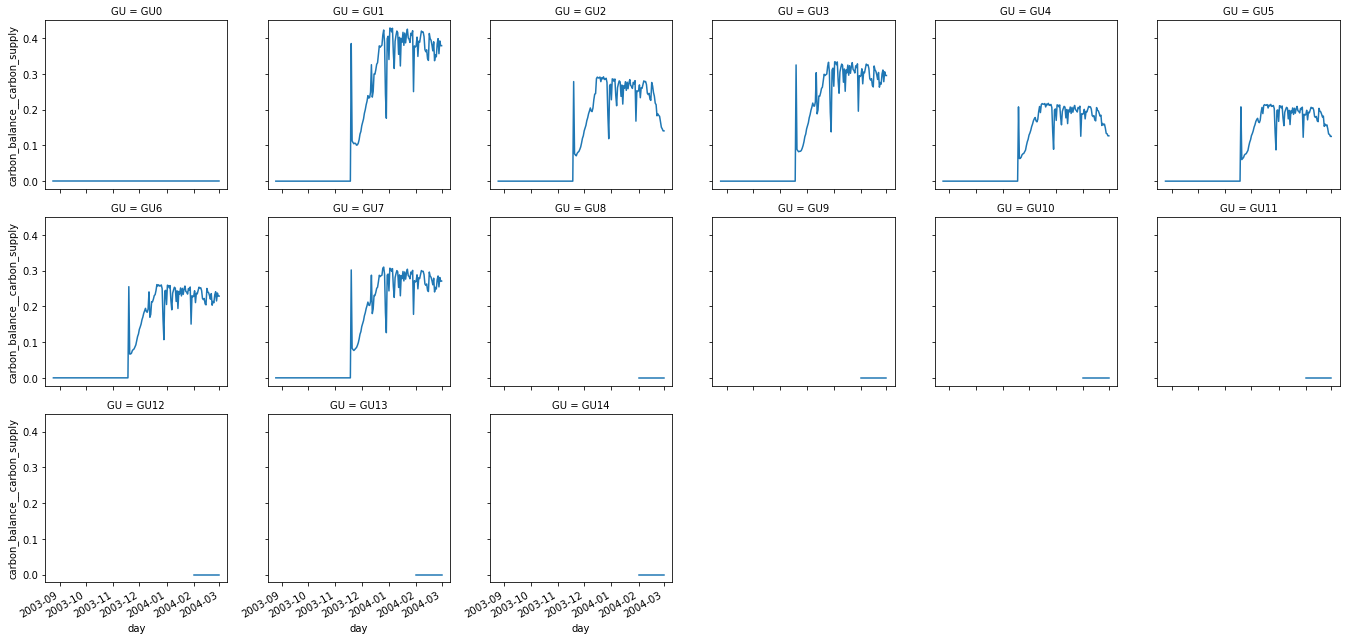

In [11]:
ds_out.carbon_balance__carbon_supply[450:,:].plot(col='GU', col_wrap=6)

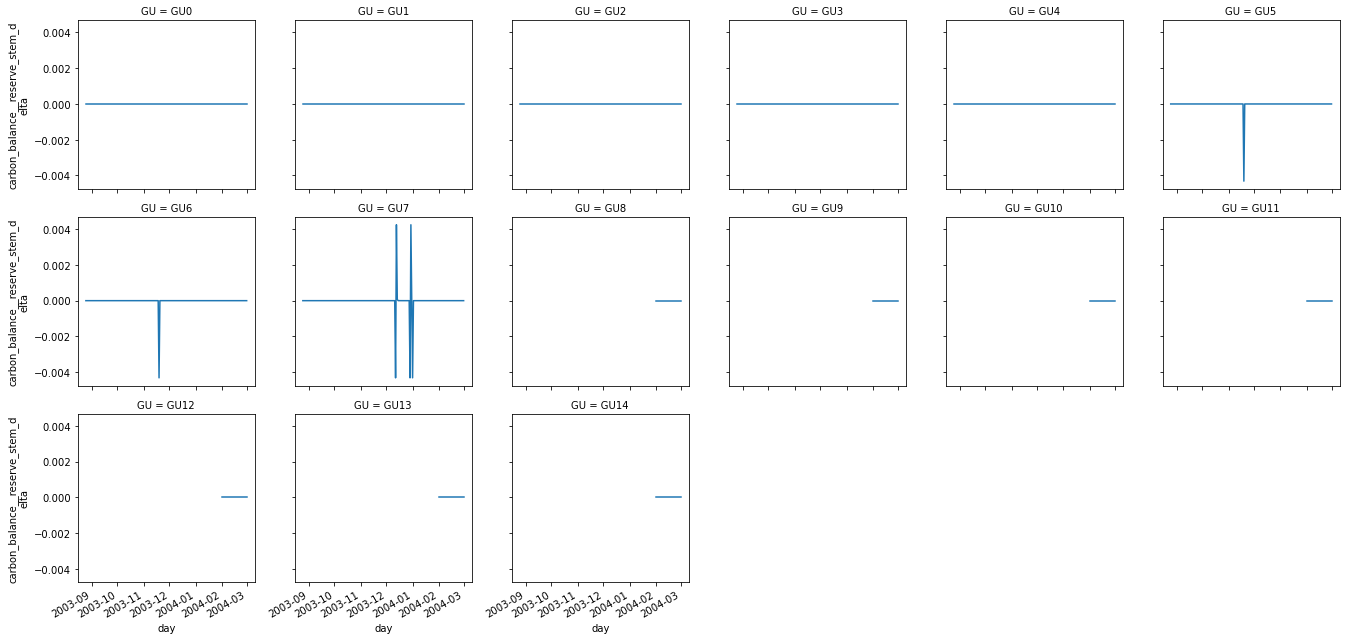

In [12]:
ds_out.carbon_balance__reserve_stem_delta[450:,:].plot(col='GU', col_wrap=6)

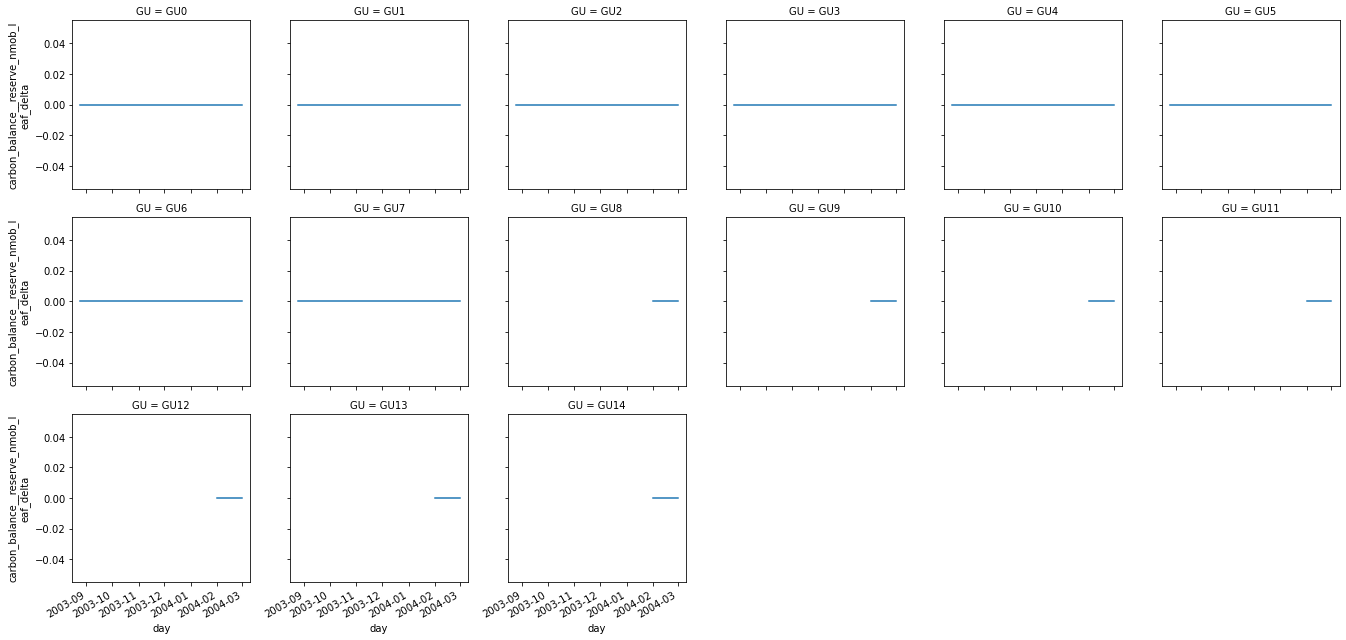

In [13]:
ds_out.carbon_balance__reserve_nmob_leaf_delta[450:,:].plot(col='GU', col_wrap=6)

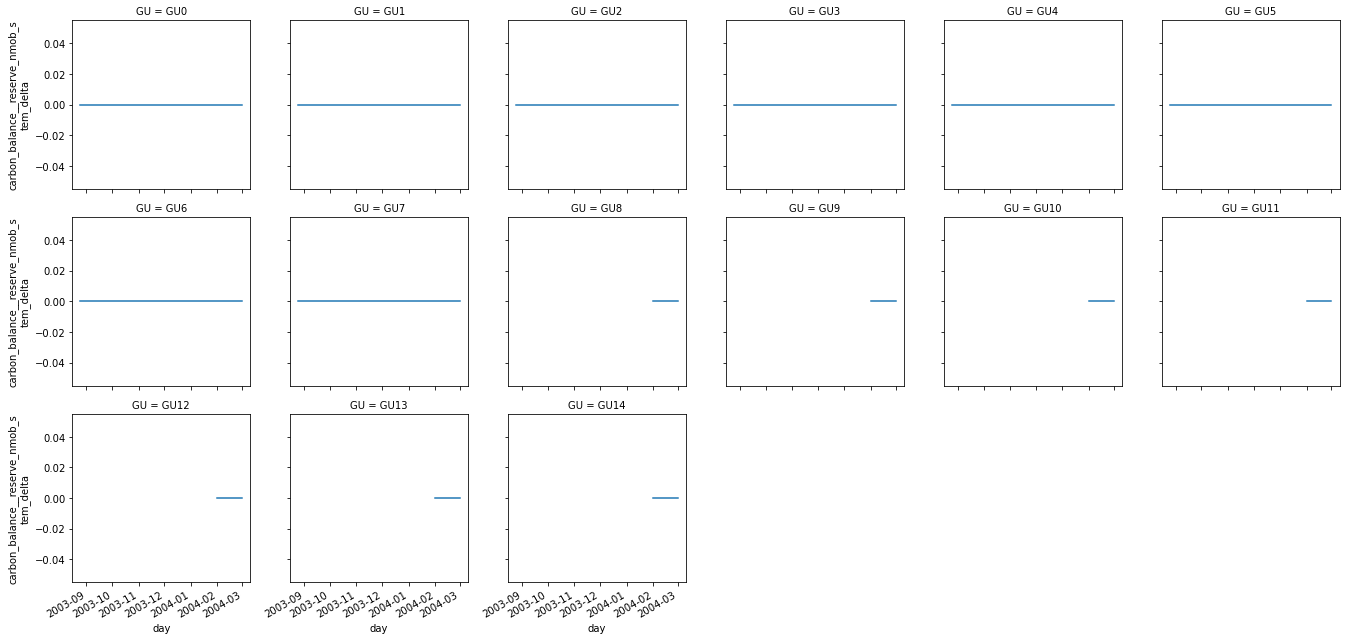

In [14]:
ds_out.carbon_balance__reserve_nmob_stem_delta[450:,:].plot(col='GU', col_wrap=6)

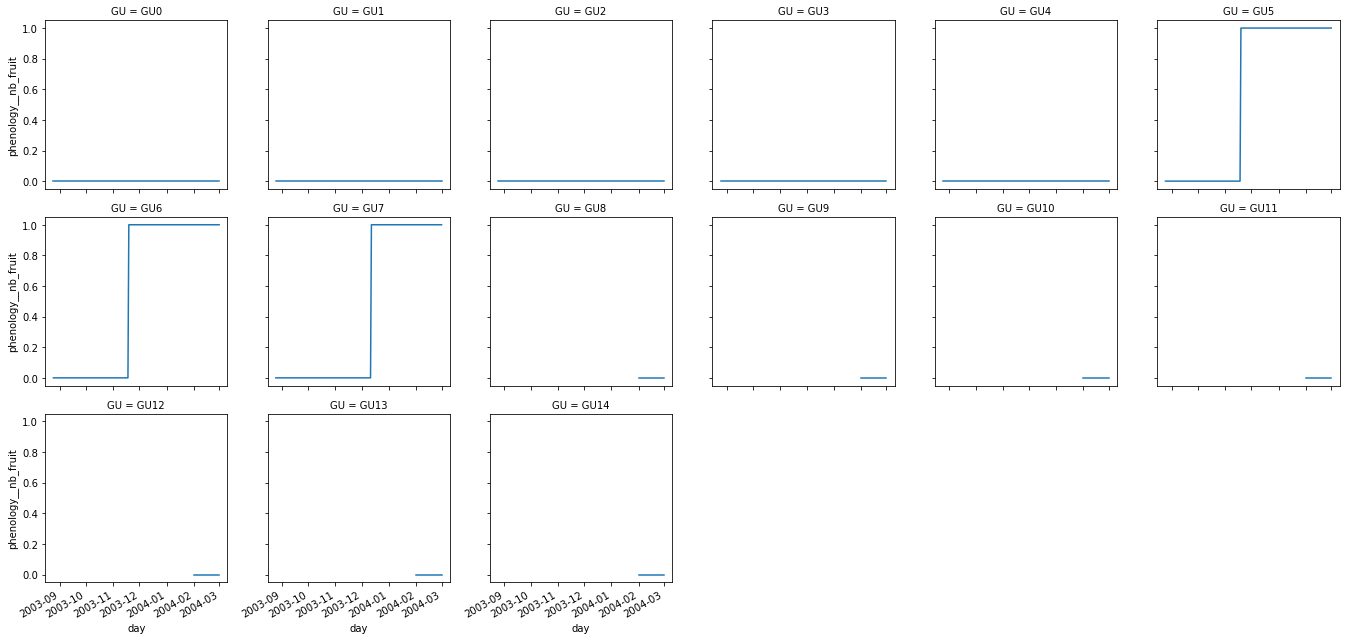

In [15]:
ds_out.phenology__nb_fruit[450:,:].plot(col='GU', col_wrap=6)

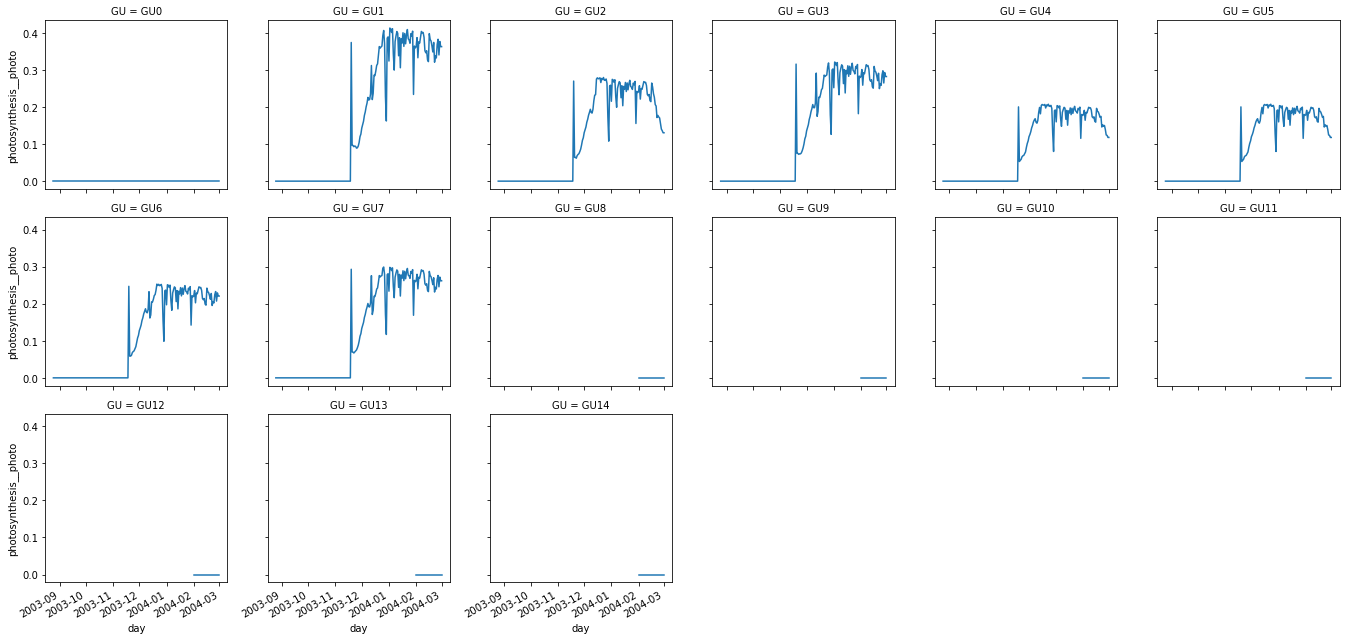

In [16]:
ds_out.photosynthesis__photo[450:,:].plot(col='GU', col_wrap=6)

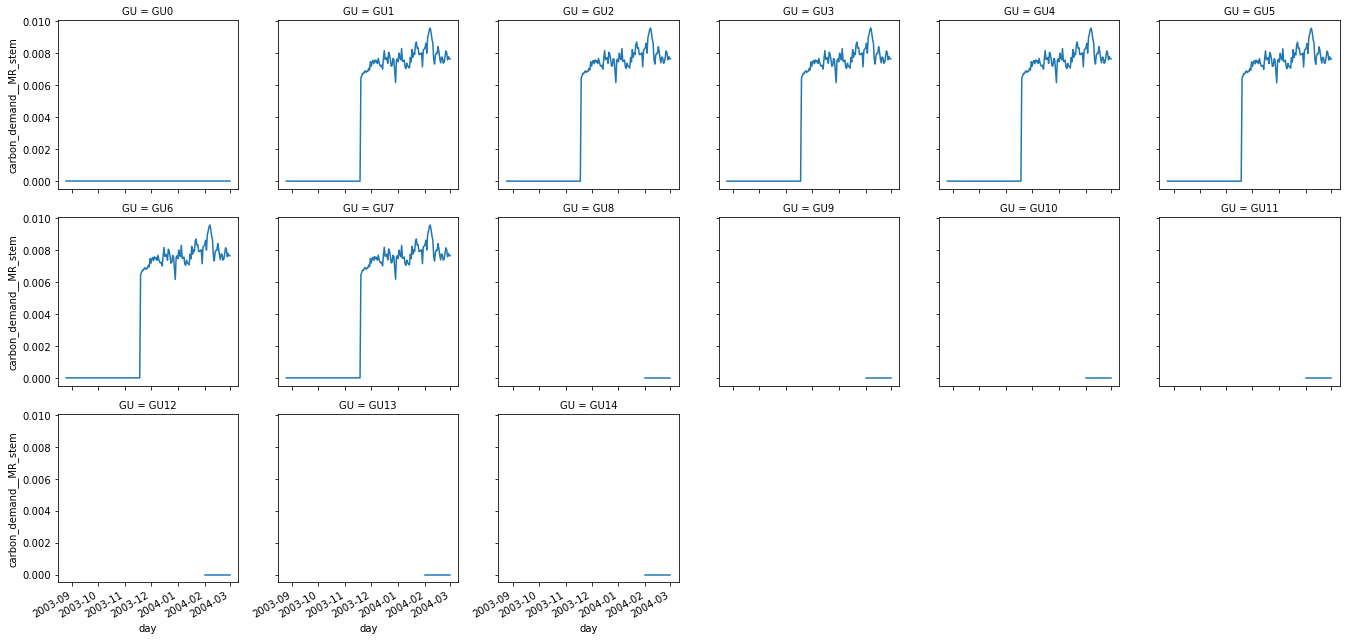

In [17]:
ds_out.carbon_demand__MR_stem[450:,:].plot(col='GU', col_wrap=6)

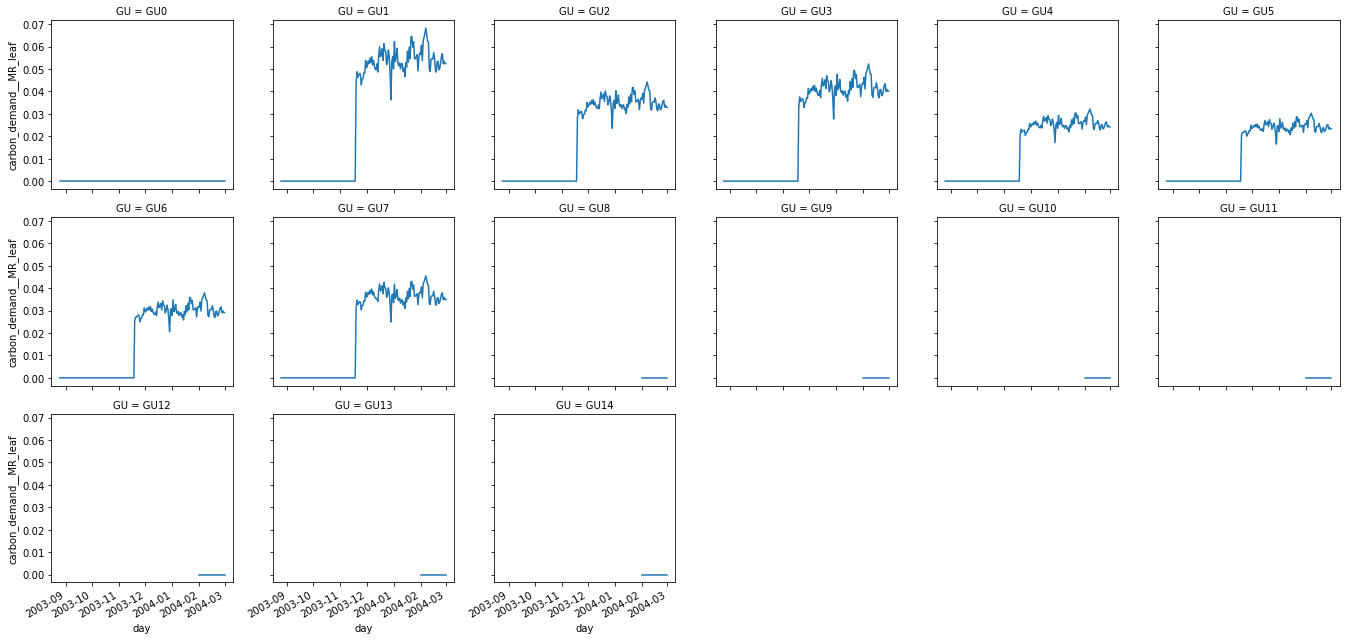

In [18]:
ds_out.carbon_demand__MR_leaf[450:,:].plot(col='GU', col_wrap=6)

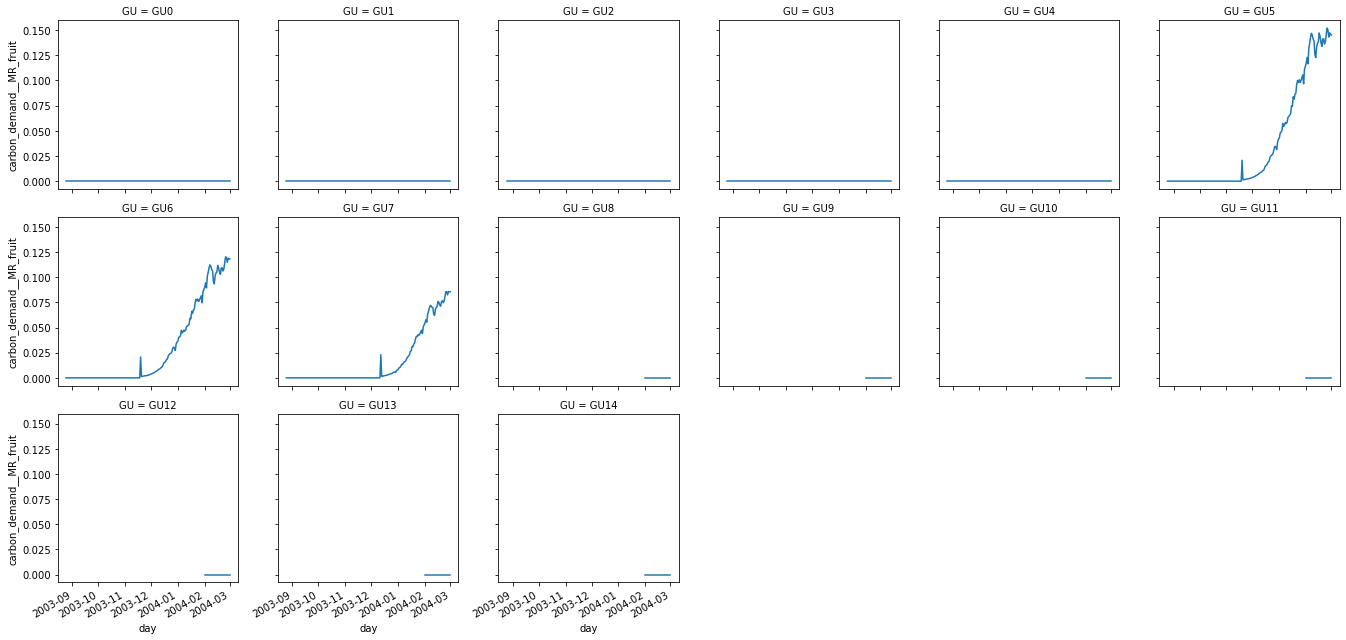

In [19]:
ds_out.carbon_demand__MR_fruit[450:,:].plot(col='GU', col_wrap=6)

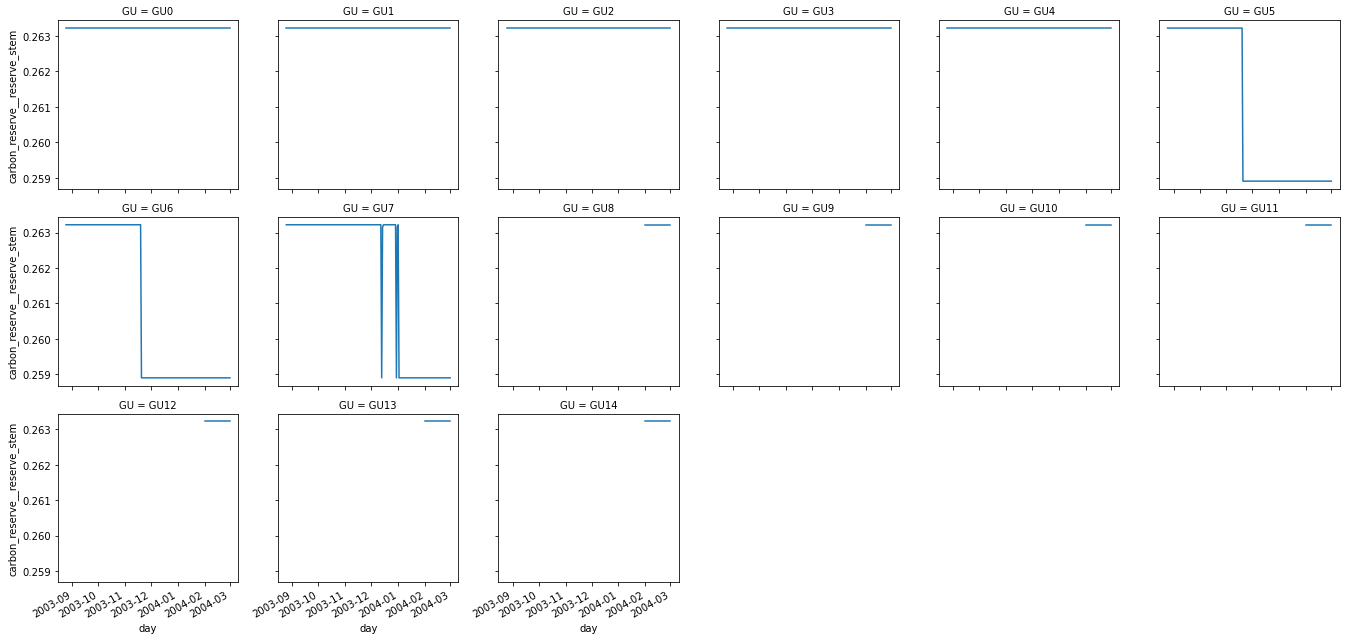

In [20]:
ds_out.carbon_reserve__reserve_stem[450:,:].plot(col='GU', col_wrap=6)

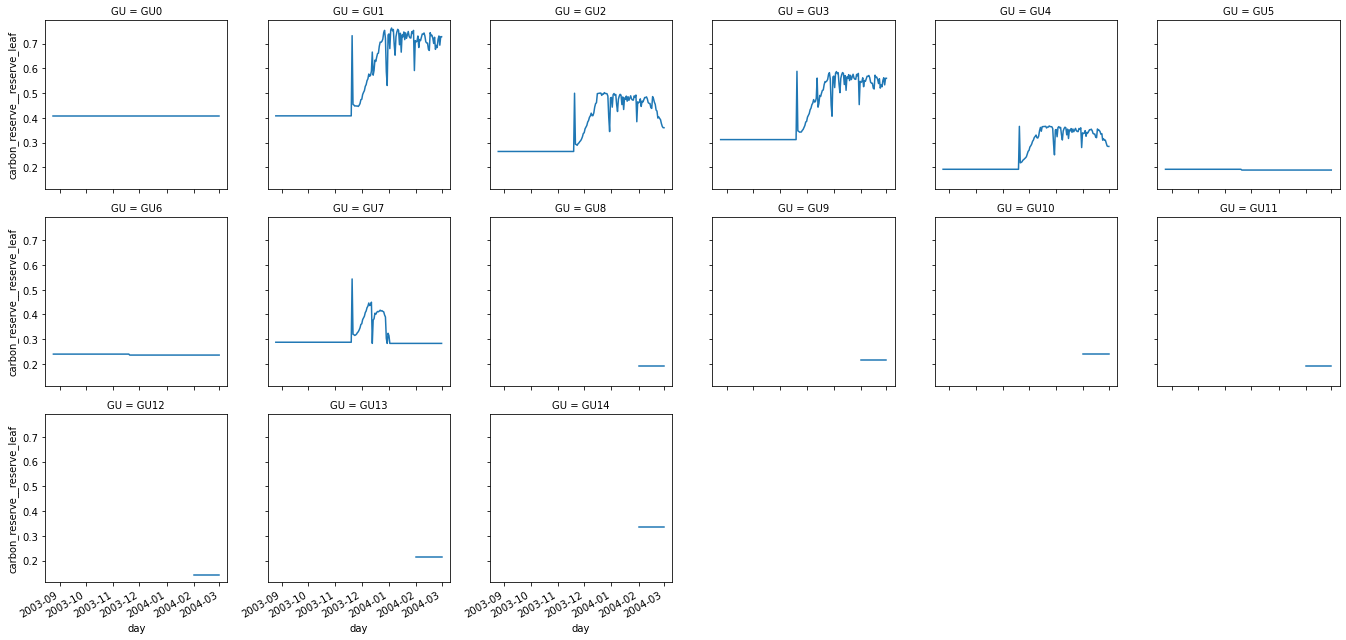

In [21]:
ds_out.carbon_reserve__reserve_leaf[450:,:].plot(col='GU', col_wrap=6)

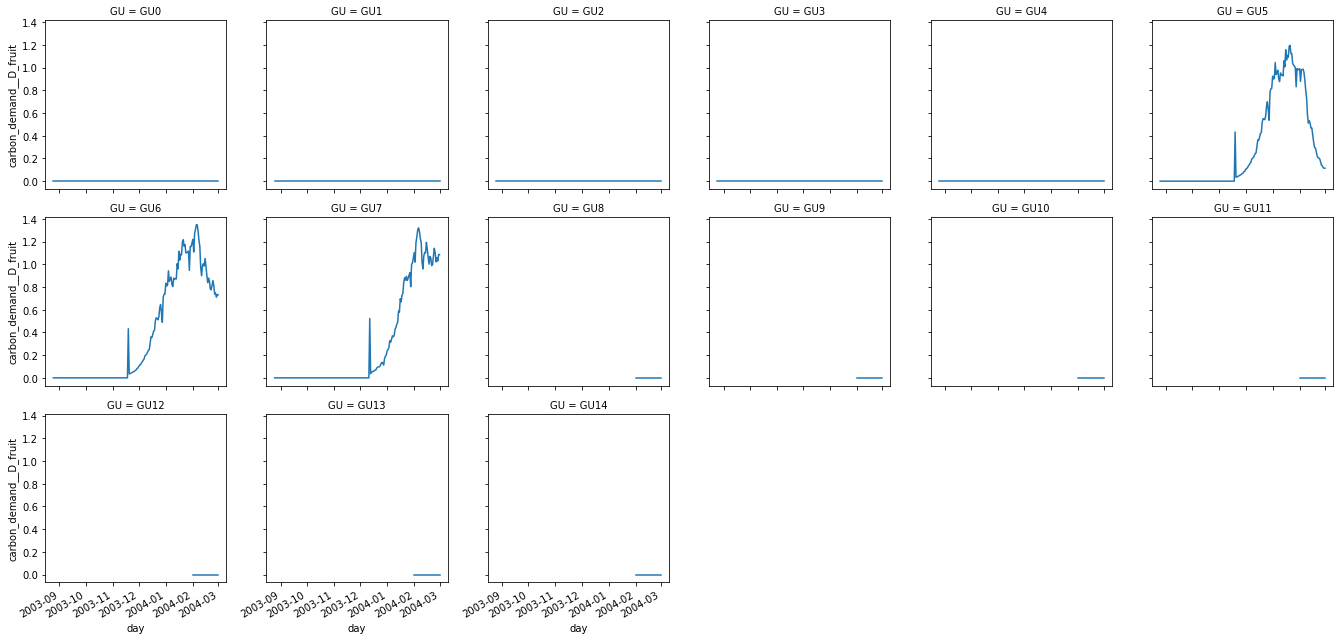

In [22]:
ds_out.carbon_demand__D_fruit[450:,:].plot(col='GU', col_wrap=6)

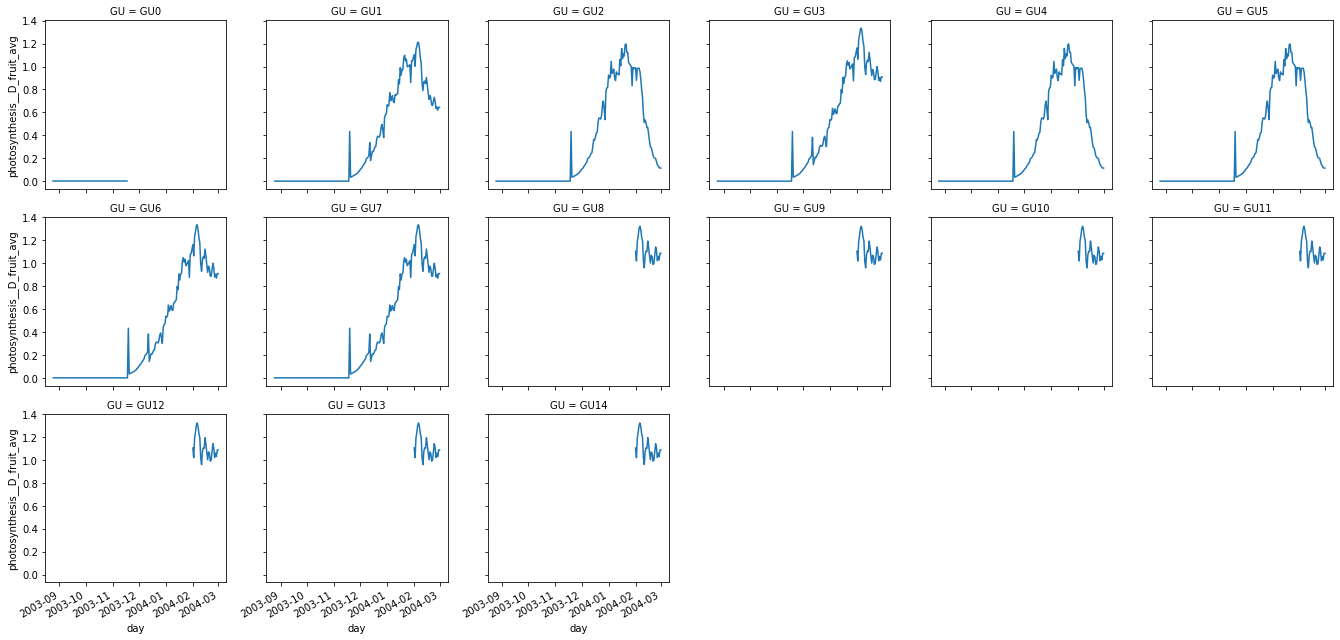

In [23]:
ds_out.photosynthesis__D_fruit_avg[450:,:].plot(col='GU', col_wrap=6)

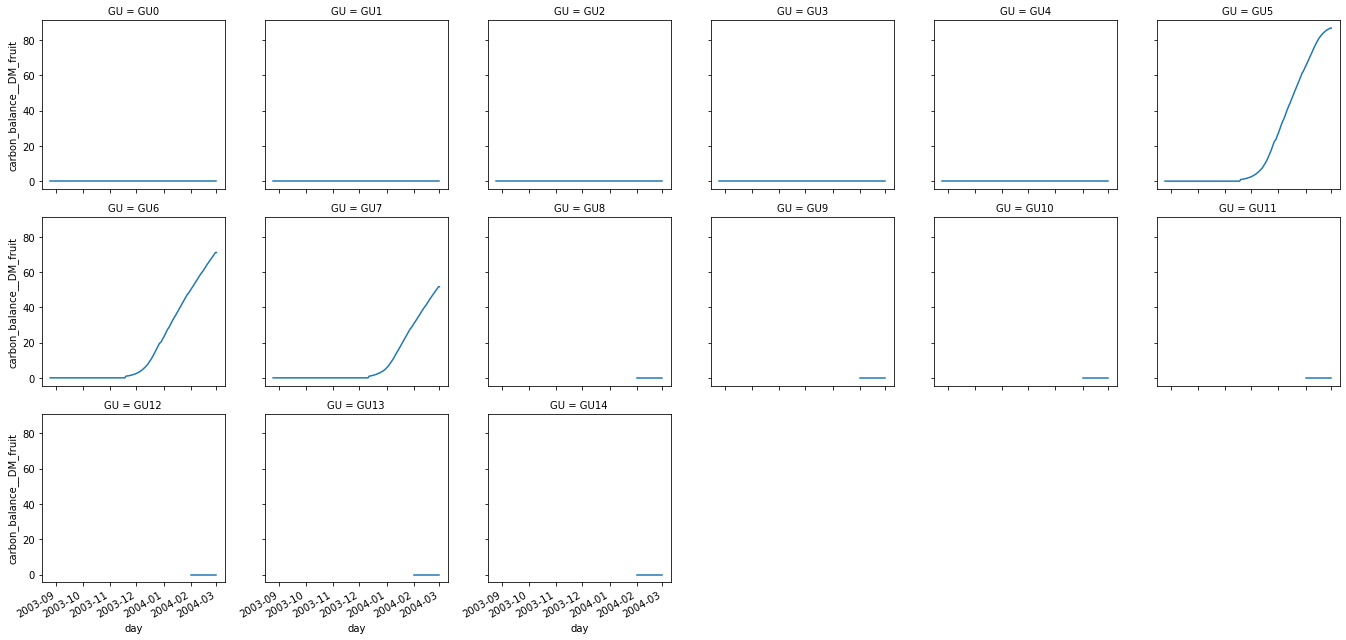

In [24]:
ds_out.carbon_balance__DM_fruit[450:,:].plot(col='GU', col_wrap=6)

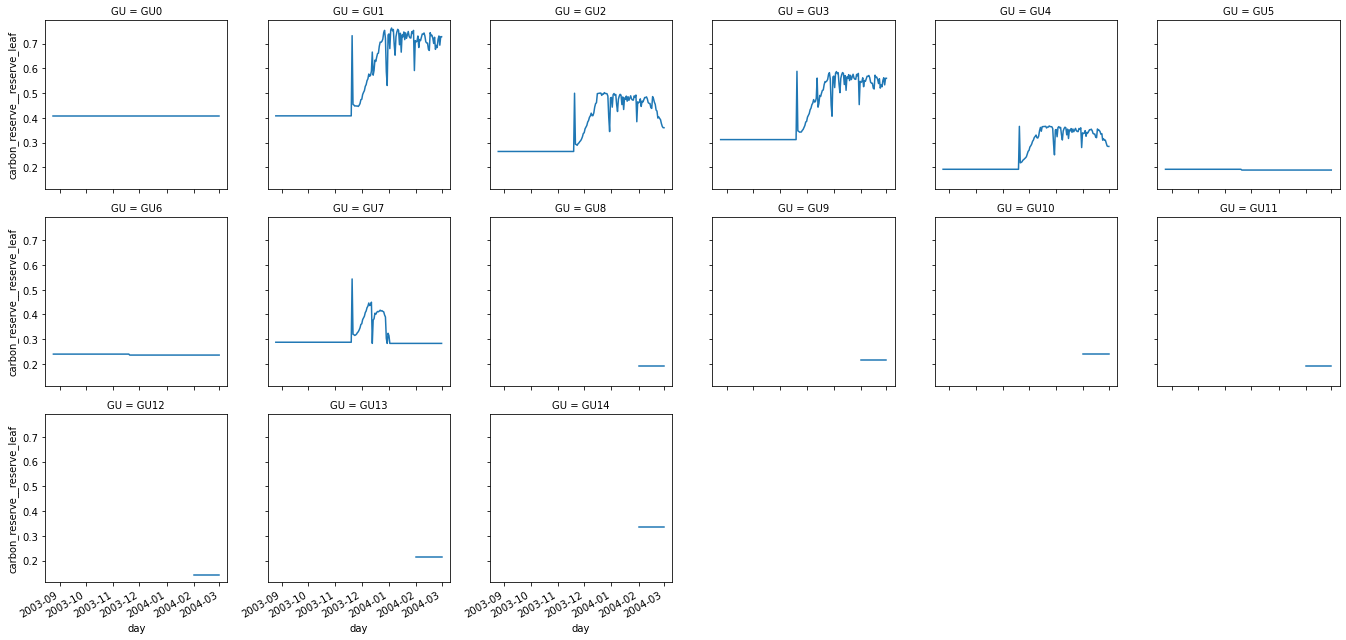

In [25]:
ds_out.carbon_reserve__reserve_leaf[450:,:].plot(col='GU', col_wrap=6)

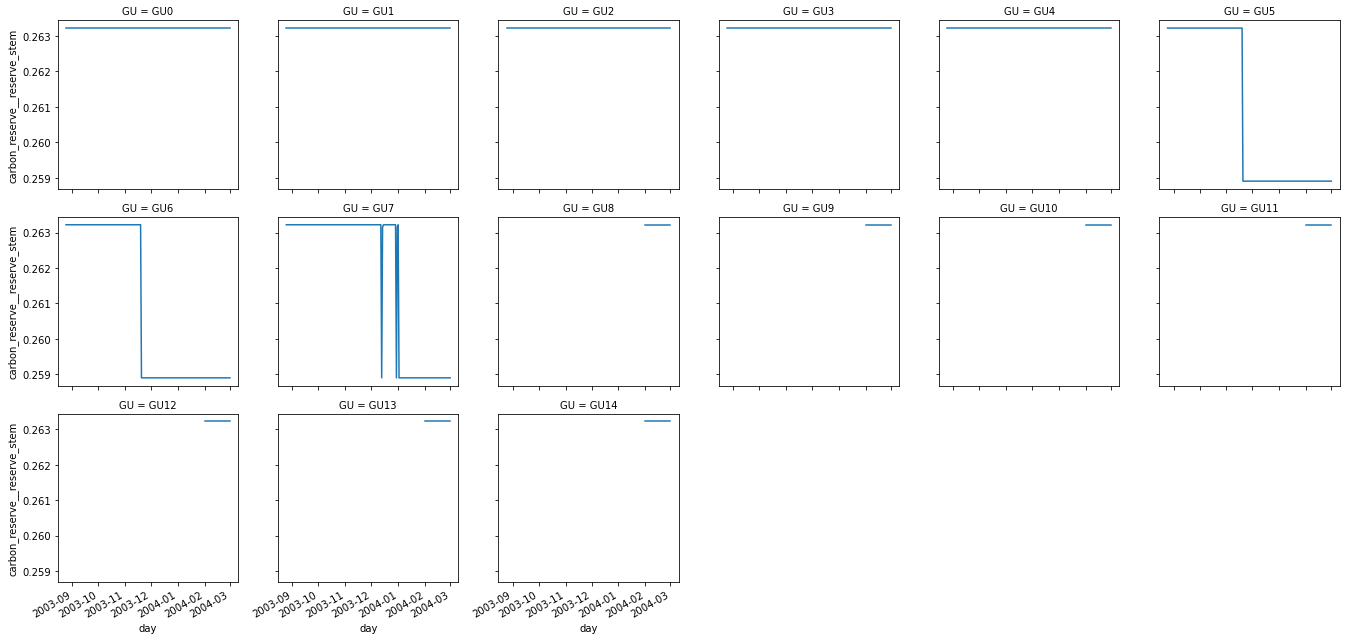

In [26]:
ds_out.carbon_reserve__reserve_stem[450:,:].plot(col='GU', col_wrap=6)

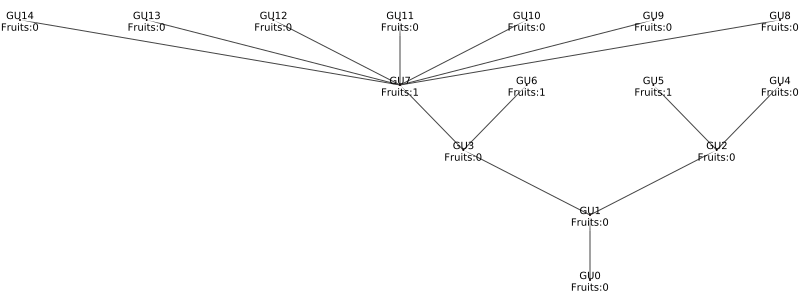

In [27]:
g = ig.Graph.Adjacency([row.tolist() for row in ds_out.topology__adjacency[-1].data.astype(np.int64)])
layout = g.layout_reingold_tilford(root=0.)
layout.rotate(-180)
ig.plot(g, layout=layout, bbox=(800, 300), **{
    'vertex_size': 1,
    'vertex_label_size': 10,
    'edge_arrow_width': 0.1,
    'vertex_label': [
        f'GU{idx}\nFruits:{int(ds_out.phenology__nb_fruit[-1].data[idx])}' for idx in g.vs.indices
    ]
})